# KHDLUD Team 10

Thành viên:<br>
Trần Quốc Long - 18120202
<br>Nguyễn Huy Danh - 1712318
<br>Trần Đức Anh - 18120280
<br>Du Chí Nhân - 18120492

In [ ]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 35.25GB
Available: 33.77GB
Used: 1.04GB
Percentage: 4.2%


# Setup

In [ ]:
# data mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Lib

import numpy as np
import pandas as pd
import gc, os

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

from multiprocessing import cpu_count
from tqdm import tqdm
from matplotlib import pyplot as plt

In [ ]:
# const

test_original_data  = '/content/drive/My Drive/KHDLUD/src/input/test.csv'
train_original_data = '/content/drive/My Drive/KHDLUD/src/input/train.csv'
sample_submission_file = '/content/drive/My Drive/KHDLUD/src/input/sample_submission.csv'
SUBMIT_FILE_PATH = f'/content/drive/My Drive/KHDLUD/src/output/2nd-place-solution.csv.gz'
OUT_PUT = '/content/drive/My Drive/KHDLUD/src/output/'

## 1. Giới thiệu

### Link cuộc thi

kaggle competion:
https://www.kaggle.com/c/santander-customer-transaction-prediction#
    
solution git:
https://github.com/KazukiOnodera/Santander-Customer-Transaction-Prediction/blob/master/final_solution/akiyama/py/lgb_train_and_predict.py

golf src:
https://github.com/KazukiOnodera/santander-customer-transaction-prediction/blob/master/py/990_2nd_place_solution_golf.py

### Giới thiệu chủ đề: 

Tại Santander, sứ mệnh của chúng tôi là giúp mọi người và doanh nghiệp phát triển thịnh vượng. Chúng tôi luôn tìm cách giúp khách hàng hiểu được sức khỏe tài chính của họ và xác định những sản phẩm và dịch vụ nào có thể giúp họ đạt được các mục tiêu về tiền tệ của mình.

Nhóm khoa học dữ liệu của chúng tôi liên tục thử thách các thuật toán học máy và làm việc với cộng đồng khoa học dữ liệu toàn cầu để đảm bảo chúng tôi có thể xác định chính xác hơn các cách mới để giải quyết thách thức phổ biến nhất, các vấn đề phân loại nhị phân, chẳng hạn như:

Khách hàng có hài lòng không? 
Một khách hàng sẽ mua sản phẩm này? 
Khách hàng có thể trả khoản vay này không?

**Trong thử thách này, chúng tôi mời Kagglers giúp chúng tôi xác định khách hàng nào sẽ thực hiện một giao dịch cụ thể trong tương lai, bất kể số tiền đã giao dịch. Dữ liệu được cung cấp cho cuộc thi này có cấu trúc giống với dữ liệu thực mà chúng tôi có sẵn để giải quyết vấn đề này.**

### Train data

In [ ]:
train = pd.read_csv(train_original_data)
train

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,train_199995,0,11.4880,-0.4956,8.2

### Test Data

In [ ]:
test = pd.read_csv(test_original_data)
test

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,...,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,...,30.9641,5.6723,3.6873,13.0429,-10.6572,15.5134,3.2185,9.0535,7.0535,5.3924,-0.7720,-8.1783,29.9227,-5.6274,10.5018,9.6083,-0.4935,8.1696,-4.3605,5.2110,0.4087,12.0030,-10.3812,5.8496,25.1958,-8.8468,11.8263,-8.7112,15.9072,0.9812,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,-4.7057,-3.0422,13.6751,3.8183,10.8535,14.2126,9.8837,2.6541,21.2181,20.8163,12.4666,12.3696,4.7473,2.7936,5.2189,13.5670,-15.4246,-0.1655,7.2633,3.4310,-9.1508,9.7320,3.1062,22.3076,11.9593,9.9255,4.0702,4.9934,8.0667,...,39.3654,5.5228,3.3159,4.3324,-0.5382,13.3009,3.1243,-4.1731,1.2330,6.1513,-0.0391,1.4950,16.8874,-2.9787,27.4035,15.8819,-10.9660,15.6415,-9.4056,4.4611,-3.0835,8.5549,-2.8517,13.4770,24.4721,-3.4824,4.9178,-2.0720,11.5390,1.1821,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,0.0095,-5.0659,14.0526,13.5010,8.7660,14.7352,10.0383,-15.3508,2.1273,21.4797,14.5372,12.5527,2.9707,4.2398,13.7796,14.1408,1.0061,-1.3479,5.2570,6.5911,6.2161,9.5540,2.3628,10.2124,10.8047,-2.5588,6.0720,3.2613,16.5632,...,19.7251,5.3882,3.6775,7.4753,-11.0780,24.8712,2.6415,2.2673,7.2788,5.6406,7.2048,3.4504,2.4130,11.1674,14.5499,10.6151,-5.7922,13.9407,7.1078,1.1019,9.4590,9.8243,5.9917,5.1634,8.1154,3.6638,3.3102,-19.7819,13.4499,1.3104,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,5.1025,-3.2827,14.1013,8.9672,4.7276,14.5811,11.8615,3.1480,18.0126,13.8006,1.6026,16.3059,6.7954,3.6015,13.6569,13.8807,8.6228,-2.2654,5.2255,7.0165,-15.6961,10.6239,-4.7674,17.5447,11.8668,3.0154,4.2546,6.7601,5.9613,...,22.8700,5.6688,6.1159,13.2433,-11.9785,26.2040,3.2348,-5.5775,5.7036,6.1717,-1.6039,-2.4866,17.2728,2.3640,14.0037,12.9165,-12.0311,10.1161,-8.7562,6.0889,-1.3620,10.3559,-7.4915,9.4588,3.9829,5.8580,8.3635,-24.8254,11.4928,1.6321,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,test_199995,13.

### Cách tính điểm

Kết quả sẽ được đánh giá dựa trên đối tượng đó có khả năng sẽ thanh toán trong tương lại hay không. 

Đánh giá bằng độ đo khu vực dưới đường cong ROC giữa xác suất xảy ra và kết quả mục tiêu do sự bất cân đối giữa 2 giá trị 0 và 1 ( Không và có)

0    179902
1     20098
Name: target, dtype: int64


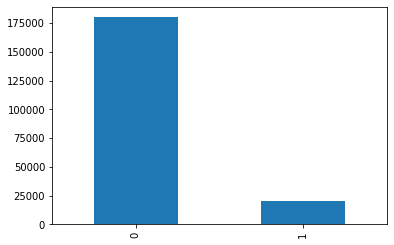

In [ ]:
target = train['target'].value_counts()
print(target)
target.plot(kind='bar')

## 2. Các bước thực hiện

In [ ]:
# config

drop_vars = [7,
            10,
            17,
            27,
            29,
            30,
            38,
            41,
            46,
            96,
            100,
            103,
            126,
            158,
            185]

var_len = 200 - len(drop_vars)
NFOLD = 10
NROUND = 1600
SEED = np.random.randint(99999)
np.random.seed(SEED)
params = {
    'bagging_freq': 5,              # tần suất bagging
    'bagging_fraction': 1.0,        ## dùng để tăng tốc training, có thể được dùng để giải quyết over-fitting
    'boost_from_average':'false',   # điều chỉnh điểm ban đầu thành giá trị trung bình của các nhãn để hội tụ nhanh hơn
    'boost': 'gbdt',                # Gradient Boosting Decision Tree truyền thống
    'feature_fraction': 1.0,        ## 1 nghĩa là LightGBM sẽ chọn toàn bộ feature trước khi training mỗi cây
                                    ## dùng để tăng tốc training, có thể được dùng để giải quyết over-fitting
    'learning_rate': 0.005,         '''
                                    quá nhỏ: hội tụ về phía mức lỗi tối thiểu, tăng lượng thời gian cần thiết để đào tạo mô hình.
                                    quá cao: Điều này sẽ làm cho quá trình training không ổn định, kết quả thiếu chính xác nhưng thời gian training nhanh hơn.
                                    '''
    'max_depth': -1,                ## giới hạn độ sâu tối đa cho cây. 
                                    # được sử dụng để đối phó vớiover-fitting khi dữ liệu nhỏ. -1 nghĩa là không giới hạn
    'metric':'binary_logloss',      ##
    'min_data_in_leaf': 30,         # số lượng dữ liệu tối thiểu trong một lá. Có thể được sử dụng để đối phó với over-fitting
    'min_sum_hessian_in_leaf': 10.0,# Giống như min_data_in_leaf, có thể được sử dụng để đối phó với over-fitting 
    'num_leaves': 64,               # số lượng lá tối đa trong một cây
    'num_threads': cpu_count(),     # sử dụng toàn bộ số lượng CPU trong hệ thống
    'tree_learner': 'serial',       # single machine tree learner
    'objective': 'binary',          # binary log loss classification
    'verbosity': -1                 # kiểm soát mức độ chi tiết của LightGBM
    }

### 1. Loại bỏ những giá trị giả

Link: https://www.kaggle.com/yag320/list-of-fake-samples-and-public-private-lb-split

Input: Dữ liệu của tập test

Output: Dữ liệu của tập test đã được loại bỏ dữ liệu giả (Fake Samples)

Mục đích: Sau khi kiểm tra tập test và tập train thì một điều bất cập đã được nhận ra là: Trong trong tập test có các giá trị độc nhất ở trên từng tính trạng khác với tập train. Tác giả đã đoán rằng người ta đã sử dụng kĩ thuật sampling distributions (phân phối mẫu) từ dữ liệu mẫu thật trong thống kê để tạo ra một số mẫu tổng hợp trong dữ liệu test. Và chúng ta sẽ lọc đi những mẫu dữ liệu giả ấy vì những mẫu giả ấy sẽ không đóng vai trò tính điểm trong tập test chính thức.

Quy trình thực hiện: Dựa trên kiến thức về phân phối mẫu, tác giả đã nghĩ ra một cách để phân loại các dữ liệu giả đấy khi kiểm tra đó chính là<br>
+Nếu 1 mẫu có ít nhất 1 tính trạng mang giá trị độc nhất thì đó sẽ là mẫu thật<br>
+Nếu 1 mẫu sau khi kiểm tra toàn bộ đều không có giá trị độc nhất thì đó chính là mẫu giả.


In [ ]:
%%time

te_ = pd.read_csv(test_original_data).drop(['ID_code'], axis=1).values

unique_samples = []
unique_count = np.zeros_like(te_)
for feature in tqdm(range(te_.shape[1])):
    _, index_, count_ = np.unique(te_[:, feature], return_counts=True, return_index=True)
    unique_count[index_[count_ == 1], feature] += 1

real_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) > 0)[:, 0]
synthetic_samples_indexes = np.argwhere(np.sum(unique_count, axis=1) == 0)[:, 0]

100%|██████████| 200/200 [00:05<00:00, 34.43it/s]

CPU times: user 11.5 s, sys: 305 ms, total: 11.8 s
Wall time: 11.9 s


In [ ]:
# real data

real_samples_indexes

array([     3,      7,     11, ..., 199995, 199996, 199999])

In [ ]:
# fake data

synthetic_samples_indexes

array([     0,      1,      2, ..., 199994, 199997, 199998])

### 2. Ghép tập train và tập test sau đó nghịch đảo một số tính trạng

Link: https://www.kaggle.com/sibmike/are-vars-mixed-up-time-intervals

Input: Dữ liệu của tập test và tập train

Output: Dữ liệu dùng để xử sau khi kết hợp và nghịch đảo

Mục đích: 
Để đưa tập train và test về phân phối giống nhau -> cải thiện hiệu quả quá trình huấn luyện

Sau khi kiểm tra xác suất xảy ra bằng phân phối bayes chúng ta thấy được có 2 loại biểu đồ là biểu đồ có xác suất P lệch về bên trái và lệch về bên phải. Chúng ta sẽ nghịch đảo 1 loại biểu đồ lại để cho các điểm tương đồng trở nên rõ ràng hơn.

Quy trình thực hiện: Chúng ta sẽ tìm ở trên tập biểu đồ những biểu đồ có xác suất lệch về bên phải và nghịch đảo chúng để xác suất của chúng đồng nhất về bên trái.

Before:

![](https://drive.google.com/uc?export=view&id=10WaUKsy0znLjyNuNwD5CyQu9ZKiJkZKo)

After:

![](https://drive.google.com/uc?export=view&id=1SVOB8U8O1PdDPuByR5Ao5wlrZw94TC0y)

In [ ]:
%%time

train = pd.read_csv(train_original_data)
test  = pd.read_csv(test_original_data).drop(synthetic_samples_indexes)

X_train = train.iloc[:, 2:].values
y_train = train.target.values

X_test = test.iloc[:, 1:].values

X = np.concatenate([X_train, X_test], axis=0)
# del X_train, X_test; gc.collect()

reverse_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 11, 15, 16, 18, 19, 22, 24, 25, 26,
                27, 29, 32, 35, 37, 40, 41, 47, 48, 49, 51, 52, 53, 55, 60, 61,
                62, 65, 66, 67, 69, 70, 71, 74, 78, 79, 82, 84, 89, 90, 91, 94,
                95, 96, 97, 99, 103, 105, 106, 110, 111, 112, 118, 119, 125, 128,
                130, 133, 134, 135, 137, 138, 140, 144, 145, 147, 151, 155, 157,
                159, 161, 162, 163, 164, 167, 168, 170, 171, 173, 175, 176, 179,
                180, 181, 184, 185, 187, 189, 190, 191, 195, 196, 199,
                
                ]
old_X = X.copy()
for j in reverse_list:
    X[:, j] *= -1

CPU times: user 10.9 s, sys: 722 ms, total: 11.7 s
Wall time: 12 s


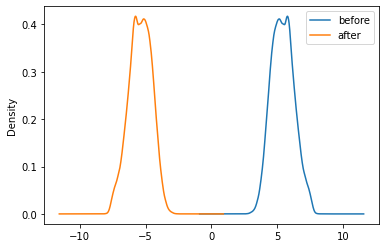

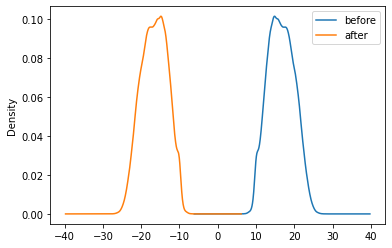

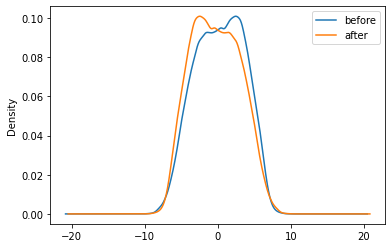

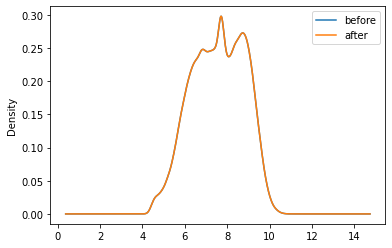

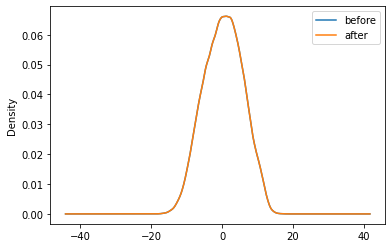

In [ ]:
for i in range(6,11):
  d = pd.DataFrame({
    'before' : old_X[:,i],
    'after': X[:,i]
  })
  ax = d.plot.kde()


### 3. Loại bỏ một số tính trạng không cần thiết và Standrad Scaling

Input: Dữ liệu sau khi đã loại bỏ fake và reverse

Output: Dữ liệu đã chuẩn hóa

Mục đích: Sau khi đã loại bỏ các mẫu fake và những giá trị gây nhiễu, chuẩn hóa dữ liệu sẽ giúp dễ dàng nhận ra các điểm dữ liệu bất thường. Ngoài ra, còn giúp tránh được những vấn đề do  sự khác biệt về độ đo, phục vụ cho việc unpivot ở bước 6

Quy trình thực hiện: 

In [ ]:
%%time

# drop
X = np.delete(X, drop_vars, 1)

# scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

CPU times: user 670 ms, sys: 82.1 ms, total: 752 ms
Wall time: 747 ms


### 4. Count round Encoding

Input: Output của bước 3

Output: Dữ liệu cũ + các cột đếm số lượng theo từng cột

Mục đích: Feature engineering, giúp cải thiện kết quả

Quy trình thực hiện:<br>
Count encoding - Với mỗi cột, đếm số lượng giá trị và tạo ra cột mới bằng cách ánh xạ: giá trị -> số lượng<br>
Count round encoding - Tương tự như 4 nhưng giá trị được làm tròn lần lượt là 1,2 và 3 chữ số thập phân rồi mới đếm

In [ ]:
# count encoding
X_cnt = np.zeros((len(X), var_len * 4))

for j in tqdm(range(var_len)):
    for i in range(1, 4):
        x = np.round(X[:, j], i+1)
        dic = pd.value_counts(x).to_dict()
        X_cnt[:, i+j*4] = pd.Series(x).map(dic)
    x = X[:, j]
    dic = pd.value_counts(x).to_dict()
    X_cnt[:, j*4] = pd.Series(x).map(dic)

100%|██████████| 185/185 [01:15<00:00,  2.44it/s]


In [ ]:
print(X)
print(X_cnt)

[[ 0.57579644  1.2744463  -0.45337987 ... -0.37591122 -1.02808669
  -0.21159897]
 [-0.27166263  0.62237198 -1.19267806 ... -0.13117217  0.82454661
  -0.50331948]
 [ 0.67985708  0.27604861 -0.51871796 ... -0.69730768 -0.38285316
  -0.35422875]
 ...
 [-0.82033404 -0.65284226  0.10555639 ...  0.26829323  0.77610176
  -0.7840257 ]
 [ 0.31528283  1.8575574   1.27626029 ...  0.2187808   0.76407362
   1.67468204]
 [ 0.06869005 -0.84888461  0.18347699 ...  1.55062165 -0.51184005
   0.42280112]]
[[   8. 1093.  122. ... 1008.  116.   12.]
 [   3.  973.   87. ... 1082.  122.   11.]
 [   6. 1015.   94. ... 1017.  108.   12.]
 ...
 [   5.  872.   90. ...  980.   97.    6.]
 [   3. 1128.  119. ...  427.   34.    7.]
 [   5. 1124.  108. ...  902.  101.    8.]]


### 5. Unpivot tất cả các cột

Input: Output của bước 4

Output: Họ cho rằng giá trị các cột là độc lập với nhau và có thể dùng giá trị của 1 cột để dự đoán target nên họ unpivot

Mục đích: Hỗ trợ dự đoán target vì họ đã thử và thấy có cải thiện kết quả

Thực hiện: Cứ mỗi biến sẽ là 6 cột (Raw_value, 4 cột đã encode, thuộc về cột nào) đem đi stack vào nhau

In [ ]:
# raw + count feature
X_raw = X.copy() # rename for readable
del X; gc.collect()

X = np.zeros((len(X_raw), var_len * 5))
for j in tqdm(range(var_len)):
    X[:, 5*j+1:5*j+5] = X_cnt[:, 4*j:4*j+4]
    X[:, 5*j] = X_raw[:, j]

100%|██████████| 185/185 [00:04<00:00, 41.21it/s]


In [ ]:
# treat each var as same
X_train_concat = np.concatenate([
    np.concatenate([
        X[:200000, 5*cnum:5*cnum+5], 
        np.ones((len(y_train), 1)).astype("int")*cnum
    ], axis=1) for cnum in range(var_len)], axis=0)
y_train_concat = np.concatenate([y_train for cnum in range(var_len)], axis=0)

### Kết quả sau khi tiền xử lý


In [ ]:
show = pd.DataFrame(X_train_concat, columns = ['raw values', 'count_1', 'count_2', 'count_3', 'count_4','var'])
show

,raw values,count_1,count_2,count_3,count_4,var
0,0.575796,8.0,1093.0,122.0,14.0,0.0
1,-0.271663,3.0,973.0,87.0,6.0,0.0
2,0.679857,6.0,1015.0,94.0,14.0,0.0
3,-0.126794,3.0,1084.0,93.0,6.0,0.0
4,0.275857,8.0,1131.0,135.0,18.0,0.0
...,...,...,...,...,...,...
36999995,1.396420,2.0,527.0,39.0,6.0,184.0
36999996,-0.348698,2.0,1017.0,113.0,13.0,184.0
36999997,-0.718784,1.0,1101.0,116.0,17.0,184.0
36999998,1.016240,1.0,800.0,68.0,6.0,184.0


### 6. Quá trình Training và Predict

Input: dữ liệu sau bước unpivot được gán tên các cột vào

Output: các model sau khi được train

Mục đích: từ data sau khi đã chuẩn hóa, tạo ra các model, dùng các model này để dự đoán

Mô tả: Trong golf solution, tác giả train và predict sử dụng Gradient Boosting với framework LightBGM



#### Về Gradient Boosting với framework LightGBM

***Gradient Boosting là gì?***


Gradient Boosting là thuật toán học máy, thường được dùng trong để hồi quy, phân loại và các tác vụ khác. Bản chất của GB là cố gắng tạo ra một phương pháp phân loại mạnh từ một số phương pháp phân loại yếu ( các cây quyết định ) . Điều này được thực hiện bằng cách xây dựng mô hình từ dữ liệu đào tạo, sau đó tạo ra một mô hình thứ hai cố gắng sửa lỗi từ mô hình đầu tiên. Các mô hình được thêm vào cho đến khi tập đào tạo được dự đoán hoàn hảo hoặc thêm một số mô hình tối đa.

nói đơn giản thì GB sẽ tạo lần lượt các cây quyết định, cây ban đầu có thể yếu, lỗi nhiều, các cây sau đó sẽ được xây dựng với mục đích giảm thiểu lỗi trên cây trước đó



***Light GBM là gì?***

Là một thuật toán thông dụng trong các cuộc thi trên Kaggle, với các ưu điểm như:

    Training nhanh hơn và hiệu quả hơn
    Ít tiêu thụ bộ nhớ
    Chính xác hơn
    Có hỗ trợ parallel, GPU,..
    ổn định để xử lý các bộ dữ liệu kích thước lớn

Trong khi đa số các thuật toán thúc đẩy ( boosting algorithm)  khác phát triễn cây theo chiều ngang ( level-wise tree growth) , LightGBM phát triễn cây theo chiều dọc (leaf-wise tree growth).

![](https://drive.google.com/uc?export=view&id=1A3Er0Ik-AVuFtzyqW4l0p8JqAVv4JM0J)


Chỗ này hiểu đơn giản thì level-wise tree growth tương tự như BFS, còn ***leaf-wise tree growth*** tương tự như DFS, sẽ mở rộng theo chiều dọc tại node cần thiết, nên là  so về hiệu quả trên cây quyết định thì leaf-wise tree growth sẽ tốt hơn cho các bộ dữ liệu kích thước lớn


#### phân chia dữ liệu cho 10-fold

Phần dữ liệu Training thì sẽ được chia ngẫu nhiên thành K phần (K trong bài toán đang sử dụng là 10). 

phân thành 2 tập, 1 tập train và valid dùng cho bước training


In [ ]:
%%time

train_group = np.arange(len(X_train_concat))%200000

id_y = pd.DataFrame(zip(train_group, y_train_concat), 
                    columns=['id', 'y'])

id_y_uq = id_y.drop_duplicates('id').reset_index(drop=True)

def stratified(nfold=5):
    
    id_y_uq0 = id_y_uq[id_y_uq.y==0].sample(frac=1)
    id_y_uq1 = id_y_uq[id_y_uq.y==1].sample(frac=1)
    
    id_y_uq0['g'] = [i%nfold for i in range(len(id_y_uq0))]
    id_y_uq1['g'] = [i%nfold for i in range(len(id_y_uq1))]
    id_y_uq_ = pd.concat([id_y_uq0, id_y_uq1])
    
    id_y_ = pd.merge(id_y[['id']], id_y_uq_, how='left', on='id')
    
    train_idx_list = []
    valid_idx_list = []
    for i in range(nfold):
        train_idx = id_y_[id_y_.g!=i].index
        train_idx_list.append(train_idx)
        valid_idx = id_y_[id_y_.g==i].index
        valid_idx_list.append(valid_idx)
    
    return train_idx_list, valid_idx_list

train_idx_list, valid_idx_list = stratified(NFOLD)

CPU times: user 44.5 s, sys: 4.28 s, total: 48.8 s
Wall time: 47.4 s


#### building model, training & predict

Train model K=10 lần, mỗi lần train sẽ chọn 1 phần làm dữ liệu validation và K-1 phần còn lại làm dữ liệu training.

Kết quả sau mỗi lần train sẽ lưu lại.

Kết quả đánh giá model cuối cùng sẽ là trung bình cộng kết quả đánh giá của K lần train trên.

In [ ]:
%%time

models = []
oof = np.zeros(len(id_y))
p_test_all = np.zeros((100000, var_len, NFOLD))
id_y['var'] = np.concatenate([np.ones(200000)*i for i in range(var_len)])

for i in  tqdm(range(NFOLD)):
    print(f'building {i}...')
    
    train_idx = train_idx_list[i]
    valid_idx = valid_idx_list[i]
    
    # train
    X_train_cv = X_train_concat[train_idx]
    y_train_cv = y_train_concat[train_idx]
    
    # valid
    X_valid = X_train_concat[valid_idx]
    
    # test
    X_test = np.concatenate([
        np.concatenate([
            X[200000:, 5*cnum:5*cnum+5], 
            np.ones((100000, 1)).astype("int")*cnum
        ], axis=1) for cnum in range(var_len)], axis=0
    )
    print('gen Dataset')
    dtrain = lgb.Dataset(
        X_train_cv, y_train_cv, 
        feature_name=['value', 'count_org', 'count_2', 'count_3', 'count_4', 'varnum'], 
        categorical_feature=['varnum'], free_raw_data=False
    )
    print('Trainning....')
    model = lgb.train(params, train_set=dtrain, num_boost_round=NROUND, verbose_eval=100)
    l = valid_idx.shape[0]

    model.save_model(OUT_PUT+'model_0612'+ str(i)+'.txt', num_iteration=model.best_iteration)
    
    print('Predicting....')
    p_valid = model.predict(X_valid)
    p_test  = model.predict(X_test)
    for j in tqdm(range(var_len)):
        oof[valid_idx] = p_valid
        p_test_all[:, j, i] = p_test[j*100000:(j+1)*100000]
    '''
        my_model.booster_.save_model('mode.txt')
        #load from model:

        bst = lgb.Booster(model_file='mode.txt')
    '''


    
    models.append(model)

10


  0%|          | 0/10 [00:00<?, ?it/s]

building 0...
gen Dataset
Trainning....


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Predicting....



 10%|█         | 1/10 [15:44<2:21:42, 944.71s/it]

building 1...
gen Dataset
Trainning....
Predicting....



 20%|██        | 2/10 [32:14<2:09:30, 971.35s/it]

building 2...
gen Dataset
Trainning....
Predicting....



 30%|███       | 3/10 [46:57<1:48:36, 930.87s/it]

building 3...
gen Dataset
Trainning....
Predicting....



 40%|████      | 4/10 [1:01:16<1:30:14, 902.44s/it]

building 4...
gen Dataset
Trainning....
Predicting....



 50%|█████     | 5/10 [1:15:42<1:14:06, 889.25s/it]

building 5...
gen Dataset
Trainning....
Predicting....



 60%|██████    | 6/10 [1:29:59<58:33, 878.44s/it]  

building 6...
gen Dataset
Trainning....
Predicting....



 70%|███████   | 7/10 [1:43:57<43:15, 865.26s/it]

building 7...
gen Dataset
Trainning....
Predicting....



 80%|████████  | 8/10 [1:57:39<28:22, 851.27s/it]

building 8...
gen Dataset
Trainning....
Predicting....



 90%|█████████ | 9/10 [2:11:30<14:05, 845.17s/it]

building 9...
gen Dataset
Trainning....
Predicting....



100%|██████████| 10/10 [2:25:06<00:00, 870.62s/it]

CPU times: user 3d 2h 42min 1s, sys: 1min 7s, total: 3d 2h 43min 8s
Wall time: 2h 25min 6s


### chuyển kết quả predict sang tỉ lệ

Do data đã được ta thay đổi để train, bộ data lúc đưa vào training có kích thước là $(200k*200, 6)$, nên ta phải biến đổi kết quả này về lại kết quả như ban đầu

Tác giả sử dụng công thức:
\begin{align}
        \frac{9*p}{1-p}
\end{align}

để đưa kết quả từ bước predict sang tỷ lệ

Kết hợp cùng với cách đánh giá dựa trên đường cong $Receiver Operating Characteristic Curve (ROC AUC)$, với $threshold >=0.500$ để ra được kết quả là tập submit cuối cùng


In [ ]:
%%time

id_y['pred'] = oof
oof = pd.pivot_table(id_y, index='id', columns='var', values='pred').values

p_test_mean = p_test_all.mean(axis=2)

p_test_odds = np.ones(100000) * 1 / 9
for j in tqdm(range(var_len)):
    if roc_auc_score(y_train, oof[:, j]) >= 0.500:
        p_test_odds *= (9 * p_test_mean[:, j] / (1 - p_test_mean[:, j]))

p_test_odds = p_test_odds / (1 + p_test_odds)

sub1 = pd.read_csv(sample_submission_file)
sub2 = pd.DataFrame({"ID_code":test.ID_code.values , "target":p_test_odds})
sub = pd.merge(sub1[["ID_code"]], sub2, how="left").fillna(0)

100%|██████████| 185/185 [00:12<00:00, 14.64it/s]


CPU times: user 39.1 s, sys: 770 ms, total: 39.8 s
Wall time: 40 s


### submit kết quả

In [ ]:
%%time

sub.to_csv(SUBMIT_FILE_PATH, index=False, compression='gzip')

CPU times: user 1.34 s, sys: 7 ms, total: 1.35 s
Wall time: 1.68 s



Kết quả từ file golf của tác giả:

![](https://drive.google.com/uc?export=view&id=1ch8qcGijBZWVv_HduumZ07R34zyks0m6)

Kết quả các lần submit:

![](https://drive.google.com/uc?export=view&id=1FonZ8wHEBEEwr8TJgkS6bhrQSnAOqvgj)
![](https://drive.google.com/uc?export=view&id=1Cqlnbmt9PQNUK6EpNzUuE54yXUnykRyl)

## Plot tree & model’s feature importances

In [ ]:
models = []
for i in range(10):
  print('Read data of model ',i)
  file =OUT_PUT+'model_0612'+ str(i)+'.txt'
  model = lgb.Booster(model_file=file)
  models.append(model)

Read data of model  0
Read data of model  1
Read data of model  2
Read data of model  3
Read data of model  4
Read data of model  5
Read data of model  6
Read data of model  7
Read data of model  8
Read data of model  9


In [ ]:
  for i in range(10):
    print('Draw tree of model ',i)
    tree_img =OUT_PUT+'tm_0612'+ str(i)+'.svg'
    tree = lgb.create_tree_digraph(model)
    with open(tree_img, 'w') as f:
      f.write(tree._repr_svg_())

Draw tree of model  0
Draw tree of model  1
Draw tree of model  2
Draw tree of model  3
Draw tree of model  4
Draw tree of model  5
Draw tree of model  6
Draw tree of model  7
Draw tree of model  8
Draw tree of model  9


Draw feature importance of model  0
Draw feature importance of model  1
Draw feature importance of model  2
Draw feature importance of model  3
Draw feature importance of model  4
Draw feature importance of model  5
Draw feature importance of model  6
Draw feature importance of model  7
Draw feature importance of model  8
Draw feature importance of model  9


'\n Với mỗi K trong khoảng từ 0-9, ta thấy mức độ quan trọng của từng thuộc tính sẽ khác nhau\n'

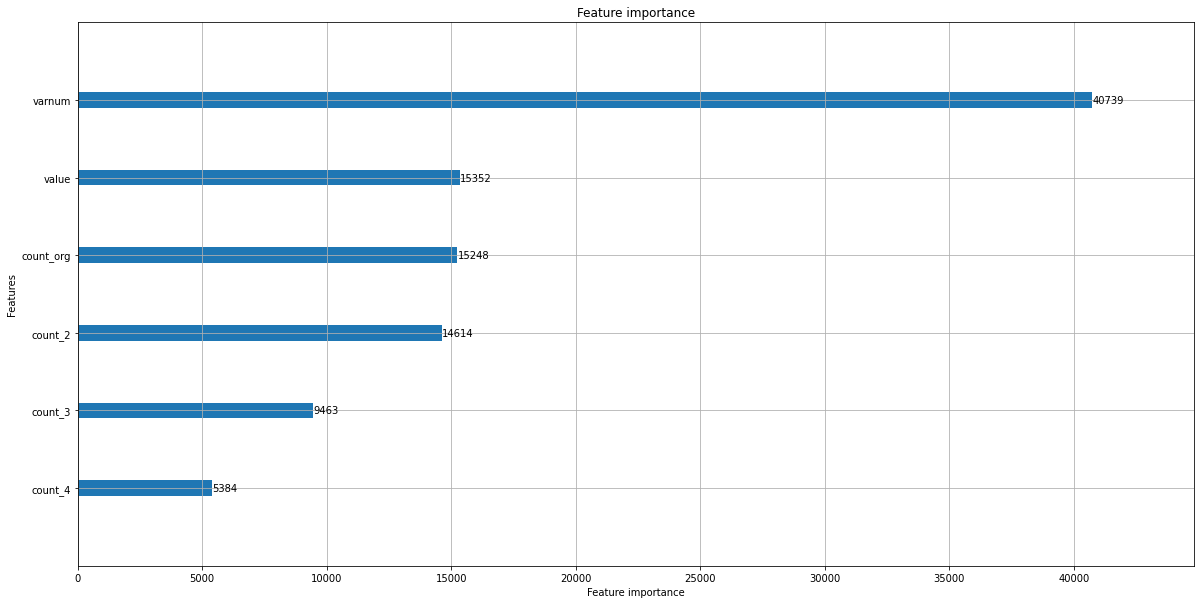

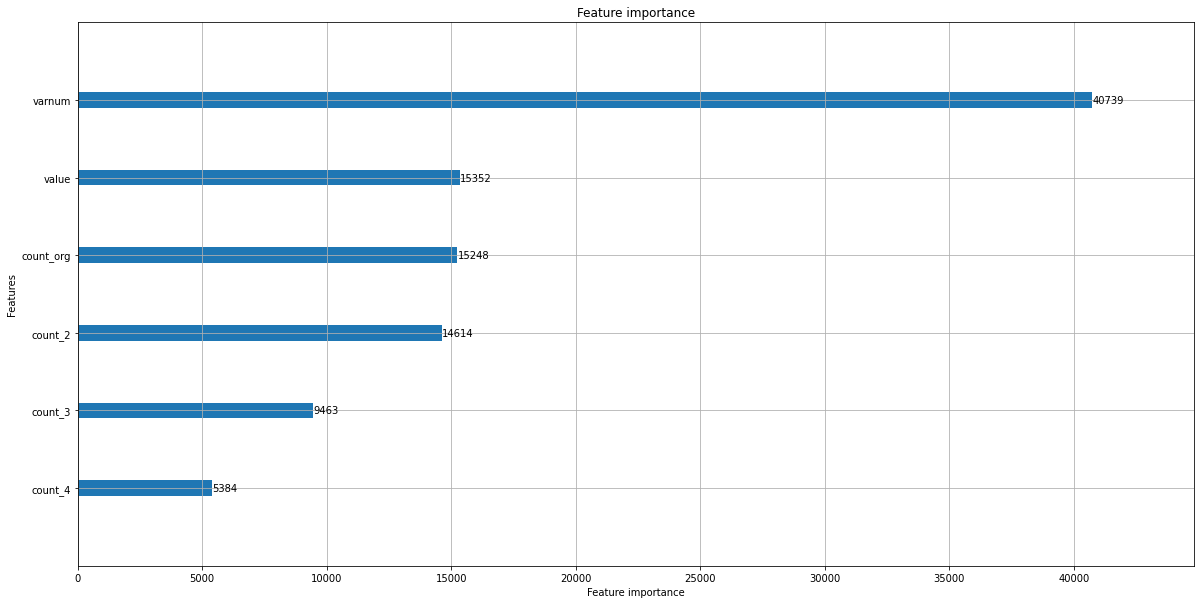

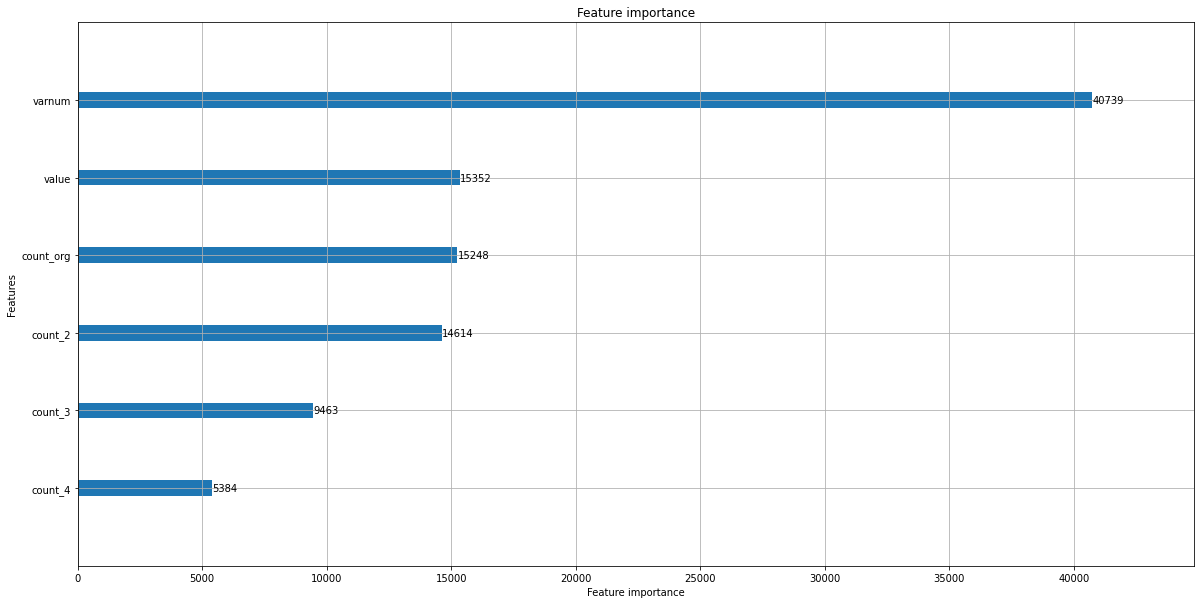

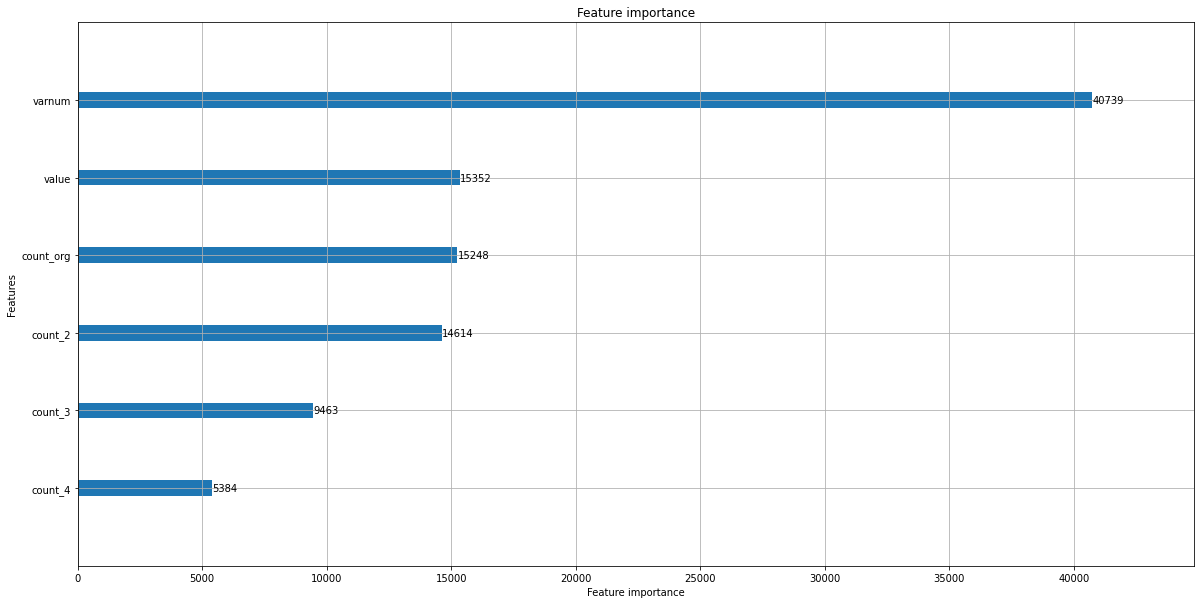

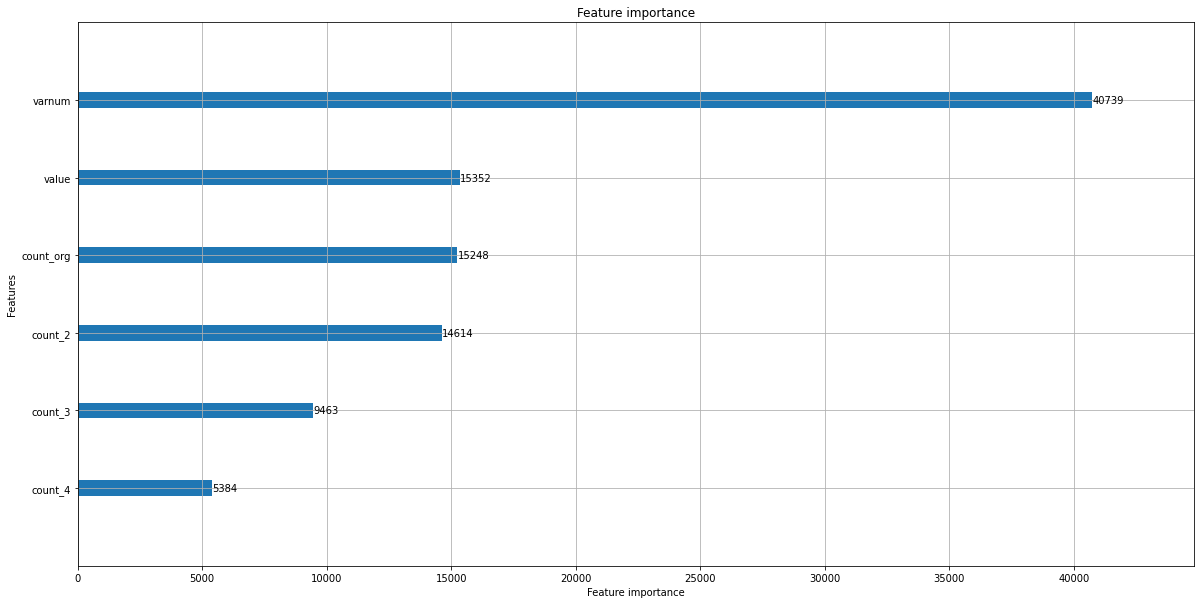

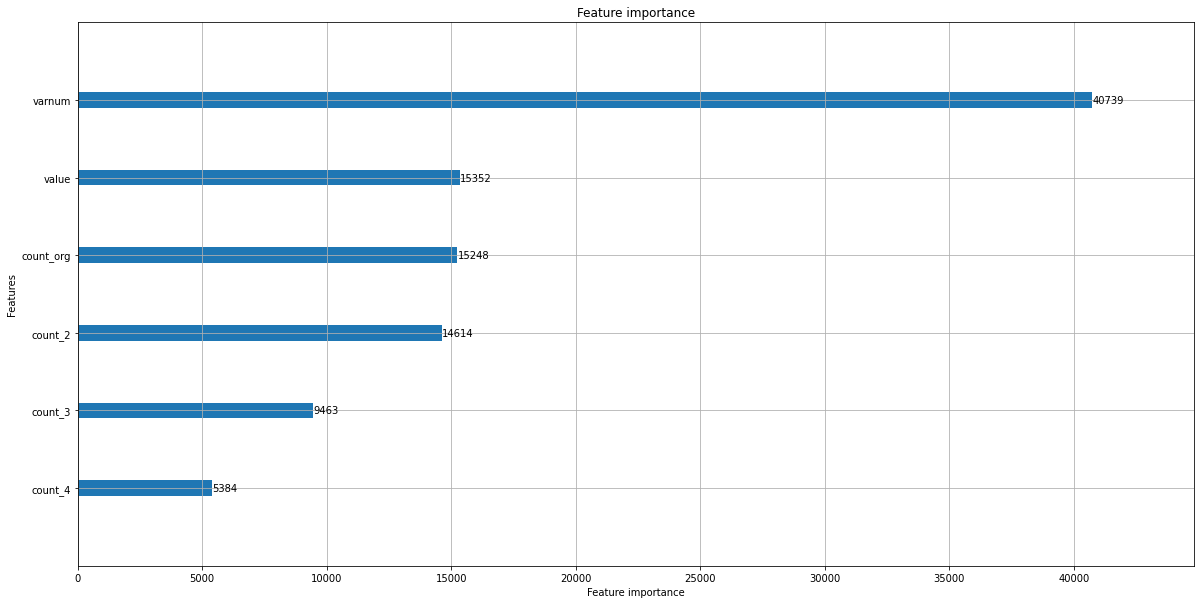

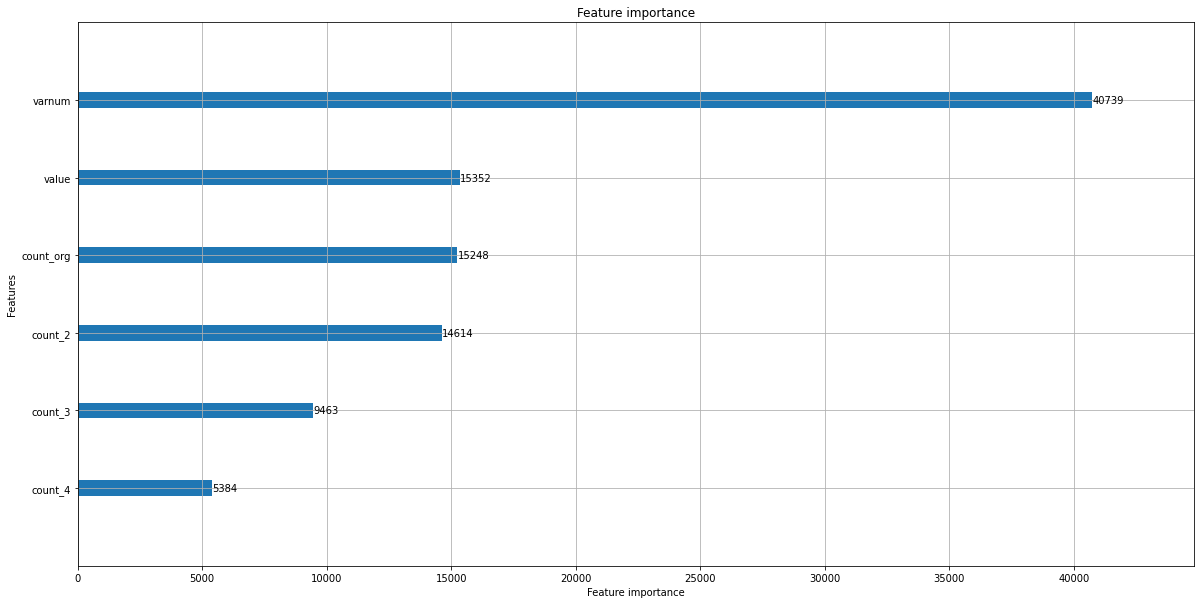

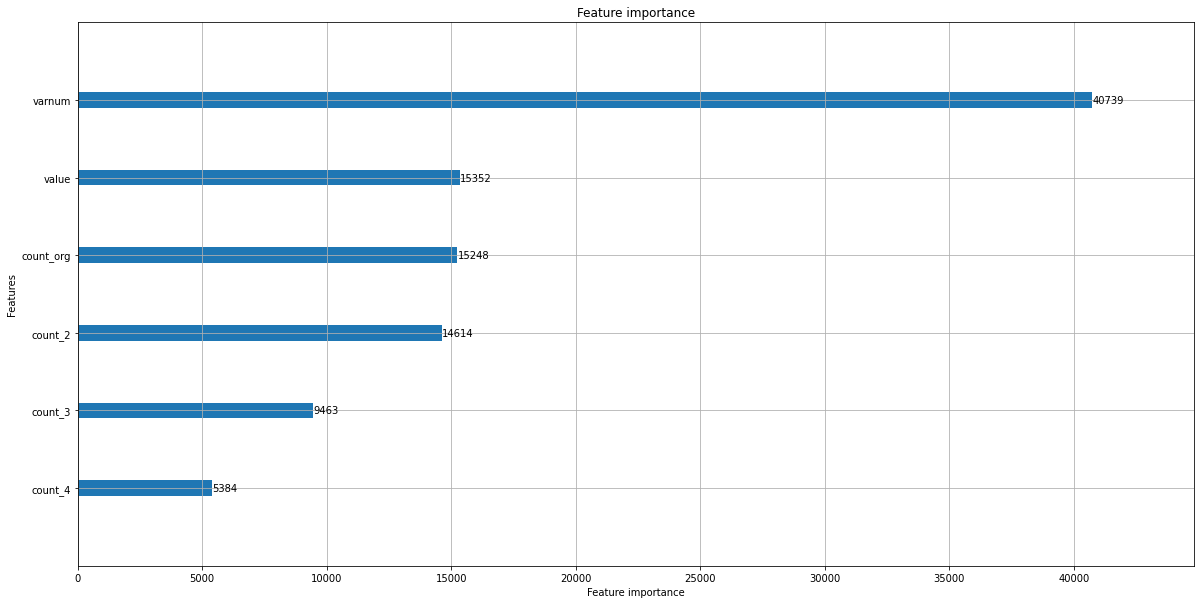

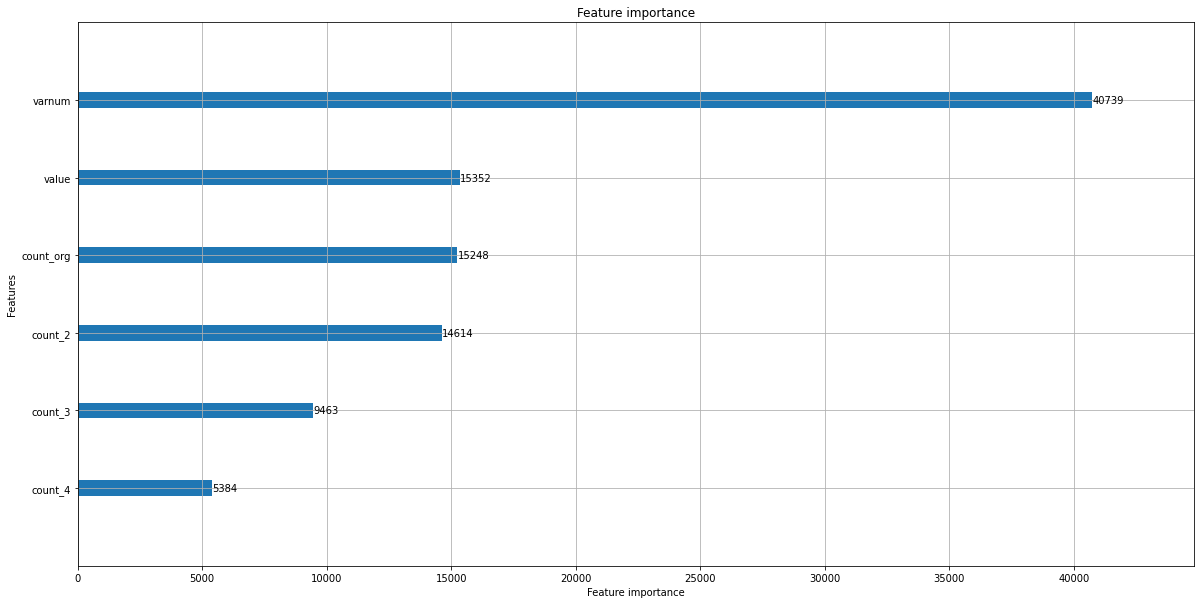

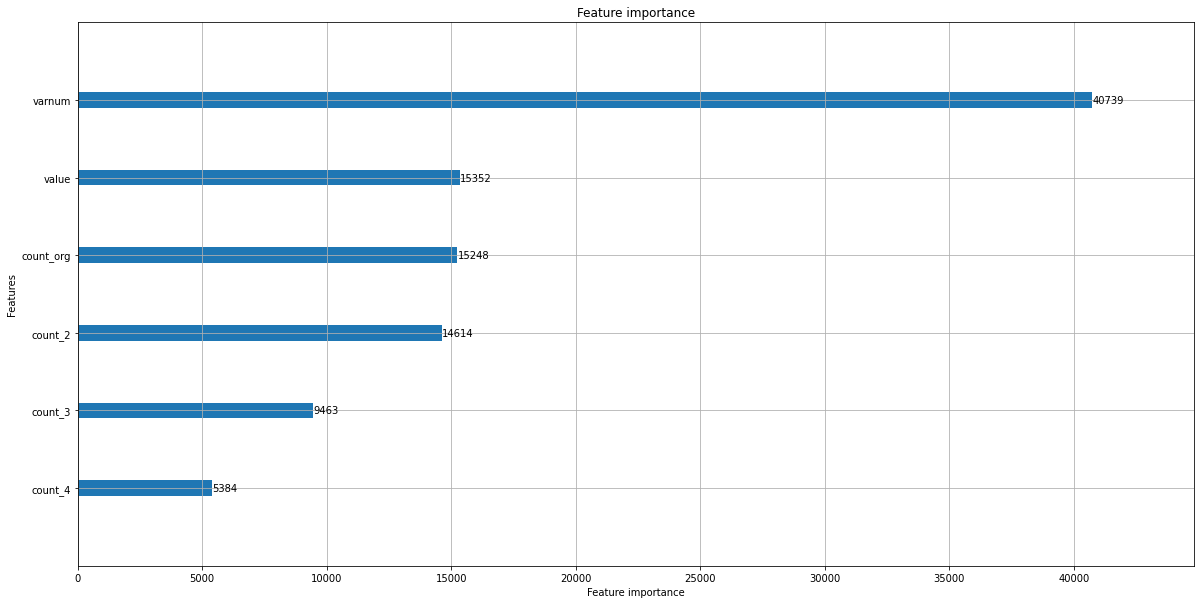

In [ ]:
  for i in range(10):
    print('Draw feature importance of model ',i)
    fig, ax = plt.subplots(figsize=(20, 10))
    lgb.plot_importance(model,ax=ax)
    feat_importance_img =OUT_PUT+'fim_0612'+ str(i)+'.svg'
    with open(feat_importance_img, 'w') as f:
      f.write(tree._repr_svg_())

### Tài liệu tham khảo


*   https://www.noron.vn/post/tim-hieu-chi-tiet-ve-auc---roc-trong-machine-learning-1fz9nhqo5ut
*   https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html




